In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!unzip "/content/drive/My Drive/RCNN/patches.zip" -d "/content/"

Archive:  /content/drive/My Drive/RCNN/patches.zip
replace /content/patches/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize

In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
image_directory = '/content/patches/images/'
mask_directory = '/content/patches/masks/'
SIZE = 256
image_dataset = []
mask_dataset = []
images = os.listdir(image_directory)
images.sort()
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))
masks = os.listdir(mask_directory)
masks.sort()
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [ ]:
image_dataset.shape

(1980, 256, 256, 1)

In [ ]:
mask_dataset.shape

(1980, 256, 256, 1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

In [ ]:
X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size = 0.10, random_state = 0)

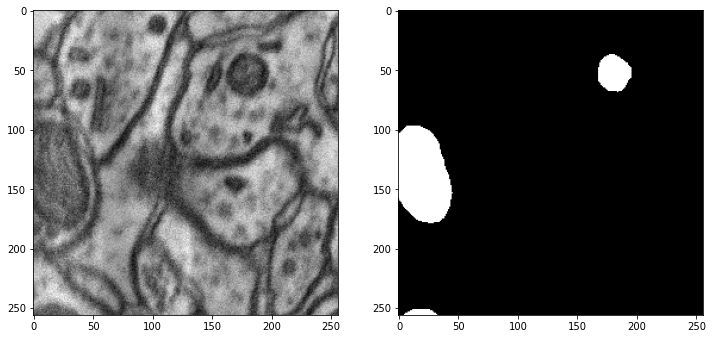

In [ ]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [ ]:
# Importation des bibliothèques
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

In [ ]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs
    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 256, 256, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

In [ ]:
history = model.fit(X_train1, y_train1, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=(50), 
                    validation_data=(X_valid, y_valid), 
                    shuffle=False)

Epoch 1/50
201/201 [==============================] - 41s 189ms/step - loss: 0.1754 - accuracy: 0.9390 - val_loss: 0.2792 - val_accuracy: 0.9401
Epoch 2/50
201/201 [==============================] - 37s 186ms/step - loss: 0.0760 - accuracy: 0.9678 - val_loss: 0.1493 - val_accuracy: 0.9346
Epoch 3/50
201/201 [==============================] - 38s 187ms/step - loss: 0.0422 - accuracy: 0.9836 - val_loss: 0.1483 - val_accuracy: 0.9341
Epoch 4/50
201/201 [==============================] - 37s 186ms/step - loss: 0.0254 - accuracy: 0.9902 - val_loss: 0.0626 - val_accuracy: 0.9746
Epoch 5/50
201/201 [==============================] - 37s 186ms/step - loss: 0.0246 - accuracy: 0.9906 - val_loss: 0.0589 - val_accuracy: 0.9809
Epoch 6/50
201/201 [==============================] - 37s 187ms/step - loss: 0.0239 - accuracy: 0.9910 - val_loss: 0.0183 - val_accuracy: 0.9926
Epoch 7/50
201/201 [==============================] - 37s 186ms/step - loss: 0.0163 - accuracy: 0.9936 - val_loss: 0.0169 - val_ac

In [ ]:
# evaluation du model
eva = model.evaluate(X_test, y_test)
print("Loss_Accuracy = ", eva)

7/7 [==============================] - 1s 175ms/step - loss: 0.0113 - accuracy: 0.9958
Loss_Accuracy =  [0.011285794898867607, 0.995826244354248]


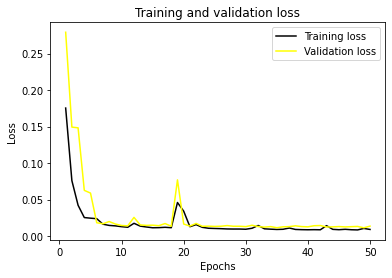

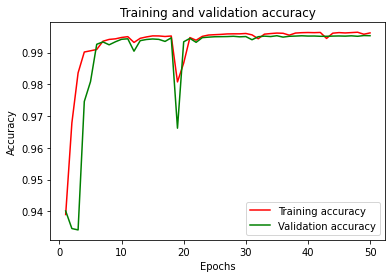

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'black', label='Training loss')
plt.plot(epochs, val_loss, 'yellow', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'red', label='Training accuracy')
plt.plot(epochs, val_acc, 'green', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre est: ", iou_score)

IoU socre est:  0.9259124996238102


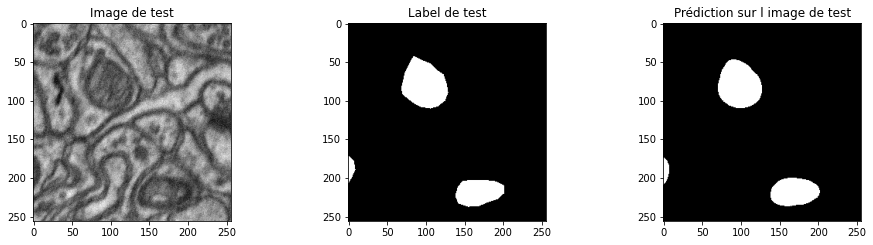

In [ ]:
# Prédire sur quelques images
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Image de test')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Label de test')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prédiction sur l image de test')
plt.imshow(prediction, cmap='gray')

plt.show()

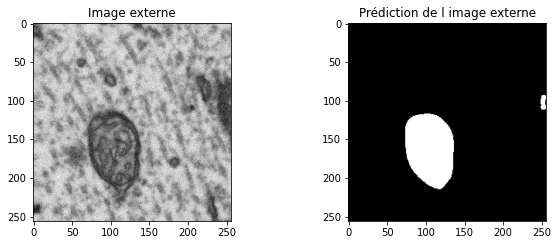

In [ ]:
# Prédire sur une image externe choisi directement sur l'ensemble de nos images

#test_img_other = cv2.imread('/content/patches/images/image_154_13.tif', 0)
test_img_other = cv2.imread('/content/patches/images/image_164_10.tif', 0)
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Image externe')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(232)
plt.title('Prédiction de l image externe')
plt.imshow(prediction_other, cmap='gray')
plt.show()